Scikit-learn HistGradientBoostingRegressor() model on MDA_dataframeArthur.csv.

Time Series cross-validation: 24h delay for weather, 1 month gap between train and test sets.
MAE en RMSE can be compared to other models.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Dataframe is loaded, datetime column is dropped in order to run model.

In [2]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
df['255439'] = df['object_id']==255439
df['255440'] = df['object_id']==255440
df['255441'] = df['object_id']==255441
df['255442'] = df['object_id']==255442
df['255443'] = df['object_id']==255443
df['255444'] = df['object_id']==255444
df['255445'] = df['object_id']==255445
df['280324'] = df['object_id']==280324
df['303910'] = df['object_id']==303910
df = df.sort_values(by=['result_timestamp','object_id'])


In [3]:
df['key'] = df['object_id'].astype('str') + df['result_timestamp']
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'],format='%Y-%m-%d %H:%M:%S')


In [4]:
df_noisedelay = df[['object_id','result_timestamp','laeq']]
df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
df_noisedelay['key'] = df_noisedelay['object_id'].astype('str') + df_noisedelay['result_timestamp'].astype('str')
df_noisedelay = df_noisedelay.drop(['laeq','object_id','result_timestamp'], axis=1)

df_weatherdelay = df[['object_id','result_timestamp','LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                   'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']]
df_weatherdelay['result_timestamp'] = df_weatherdelay['result_timestamp']+pd.DateOffset(days=1)
df_weatherdelay['key'] = df_weatherdelay['object_id'].astype('str') + df_weatherdelay['result_timestamp'].astype('str')
df_weatherdelay = df_weatherdelay.drop(['object_id','result_timestamp'], axis=1)
df = df.drop(['LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0'],axis=1)


C:\Users\Arthur\AppData\Local\Temp\ipykernel_6340\727566501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_6340\727566501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
C:\Users\Arthur\AppData\Local\Temp\ipykernel_6340\727566501.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [5]:
df = pd.merge(df,df_noisedelay, on='key',validate='1:1')
df= pd.merge(df,df_weatherdelay, on='key',validate='1:1')
df_nd = df.drop(['key','object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)

In [6]:
df_nd.isna().sum()


laeq             0
hour             0
weekday          0
month            0
weekend          0
holiday          0
exam_period      0
255439           0
255440           0
255441           0
255442           0
255443           0
255444           0
255445           0
280324           0
303910           0
laeq_delayed     0
LC_HUMIDITY     43
LC_DWPTEMP      43
LC_n            43
LC_RAD          43
LC_RAININ       43
LC_DAILYRAIN    43
LC_WINDDIR      43
LC_WINDSPEED    43
LC_RAD60         4
LC_TEMP_QCL0    43
dtype: int64

In [7]:
df_nd = df_nd[df_nd.isna()['LC_HUMIDITY']==False]
df_nd.isna().sum()

laeq            0
hour            0
weekday         0
month           0
weekend         0
holiday         0
exam_period     0
255439          0
255440          0
255441          0
255442          0
255443          0
255444          0
255445          0
280324          0
303910          0
laeq_delayed    0
LC_HUMIDITY     0
LC_DWPTEMP      0
LC_n            0
LC_RAD          0
LC_RAININ       0
LC_DAILYRAIN    0
LC_WINDDIR      0
LC_WINDSPEED    0
LC_RAD60        0
LC_TEMP_QCL0    0
dtype: int64

In [8]:
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Monday', value=0)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Tuesday', value=1)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Wednesday', value=2)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Thursday', value=3)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Friday', value=4)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Saturday', value=5)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Sunday', value=6)

The target dataset (y) and predictor dataset (X) are created. For y, noise is converted to relative noise (proportion of max value)

In [9]:
y = df_nd["laeq"]
X = df_nd.drop(["laeq","laeq_delayed"], axis="columns")

In [10]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=38880,
    max_train_size=66000,
    test_size=30000,
)

In [11]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
75280,13,5,4,True,True,False,False,False,False,False,...,56.0,8.70,32.0,420.0,0.0,0.0,110.0,0.37,496.0,17.65
75281,13,5,4,True,True,False,False,False,False,False,...,56.0,8.70,32.0,420.0,0.0,0.0,110.0,0.37,496.0,17.65
75282,13,5,4,True,True,False,False,False,False,False,...,56.0,8.70,32.0,420.0,0.0,0.0,110.0,0.37,496.0,17.65
75283,13,5,4,True,True,False,True,False,False,False,...,56.0,8.57,32.0,92.0,0.0,0.0,-44.0,0.05,492.0,17.57
75284,13,5,4,True,True,False,False,False,True,False,...,56.0,8.57,32.0,92.0,0.0,0.0,-44.0,0.05,492.0,17.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141275,1,1,6,False,False,True,False,False,False,False,...,82.0,11.85,31.0,0.0,0.0,0.0,111.0,0.05,0.0,14.76
141276,1,1,6,False,False,True,True,False,False,False,...,82.0,11.61,32.0,0.0,0.0,0.0,83.0,0.09,0.0,14.60
141277,1,1,6,False,False,True,False,True,False,False,...,82.0,11.61,32.0,0.0,0.0,0.0,83.0,0.09,0.0,14.60
141278,1,1,6,False,False,True,False,False,True,False,...,82.0,11.61,32.0,0.0,0.0,0.0,83.0,0.09,0.0,14.60


In [12]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
195280,14,5,8,True,True,False,False,False,False,False,...,21.0,7.93,32.0,550.0,0.0,0.0,94.0,0.22,578.0,33.04
195281,15,5,8,True,True,False,True,False,False,False,...,21.0,7.92,31.0,545.0,0.0,0.0,87.0,0.63,572.0,33.16
195282,15,5,8,True,True,False,False,True,False,False,...,21.0,7.92,31.0,545.0,0.0,0.0,87.0,0.63,572.0,33.16
195283,15,5,8,True,True,False,False,False,True,False,...,21.0,7.92,31.0,545.0,0.0,0.0,87.0,0.63,572.0,33.16
195284,15,5,8,True,True,False,False,False,False,True,...,21.0,7.92,31.0,545.0,0.0,0.0,87.0,0.63,572.0,33.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261314,13,0,10,False,False,False,False,False,False,False,...,70.0,14.75,37.0,114.0,0.0,0.0,-176.0,0.10,115.0,20.33
261315,13,0,10,False,False,False,False,False,False,False,...,70.0,14.75,37.0,114.0,0.0,0.0,-176.0,0.10,115.0,20.33
261316,13,0,10,False,False,False,False,False,False,False,...,70.0,14.75,37.0,114.0,0.0,0.0,-176.0,0.10,115.0,20.33
261317,13,0,10,False,False,False,False,False,False,False,...,70.0,14.75,37.0,114.0,0.0,0.0,-176.0,0.10,115.0,20.33


In [25]:
# grid search for hyperparameter tuning
param_grid = {
    'learning_rate': (0.14,0.15,0.16),
    'max_leaf_nodes': (17,18,19,20)}
model = HistGradientBoostingRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=38880, max_train_size=66000, n_splits=5, test_size=30000),
             estimator=HistGradientBoostingRegressor(), n_jobs=2,
             param_grid={'learning_rate': (0.14, 0.15, 0.16),
                         'max_leaf_nodes': (17, 18, 19, 20)})

In [26]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.80


In [27]:
model_grid_search.predict(X.iloc[0:5])

array([47.56665755, 42.51837461, 42.40446315, 40.12823005, 47.64050161])

In [28]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.16, 'max_leaf_nodes': 17}


In [29]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,7.623200,0.880827,0.219562,0.027055,0.16,17,"{'learning_rate': 0.16, 'max_leaf_nodes': 17}",0.699711,0.664479,0.205926,0.530245,0.589138,0.537900,0.176122,1
6,9.388909,0.318339,0.256262,0.075842,0.15,19,"{'learning_rate': 0.15, 'max_leaf_nodes': 19}",0.683724,0.654504,0.220601,0.533101,0.577509,0.533888,0.165560,2
9,9.547887,1.457679,0.231649,0.021723,0.16,18,"{'learning_rate': 0.16, 'max_leaf_nodes': 18}",0.686106,0.634476,0.209113,0.531532,0.573979,0.527041,0.167419,3
5,7.268307,0.072012,0.227142,0.010386,0.15,18,"{'learning_rate': 0.15, 'max_leaf_nodes': 18}",0.681877,0.655249,0.200994,0.515541,0.580139,0.526760,0.173014,4
7,9.023801,1.132269,0.257278,0.051189,0.15,20,"{'learning_rate': 0.15, 'max_leaf_nodes': 20}",0.665337,0.635803,0.209929,0.532337,0.580365,0.524754,0.163927,5


In [30]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [31]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
8,0.16,17,0.537900,0.176122,1
6,0.15,19,0.533888,0.165560,2
9,0.16,18,0.527041,0.167419,3
5,0.15,18,0.526760,0.173014,4
7,0.15,20,0.524754,0.163927,5
1,0.14,18,0.524081,0.183586,6
2,0.14,19,0.524060,0.169232,7
11,0.16,20,0.521452,0.172421,8
0,0.14,17,0.517566,0.176235,9
4,0.15,17,0.514997,0.195241,10


In [32]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_learning_rate"],
    columns=["param_max_leaf_nodes"])

pivoted_cv_results

param_max_leaf_nodes,17,18,19,20
param_learning_rate,,,,
0.14,0.517566,0.524081,0.524060,0.511626
0.15,0.514997,0.526760,0.533888,0.524754
0.16,0.537900,0.527041,0.514779,0.521452


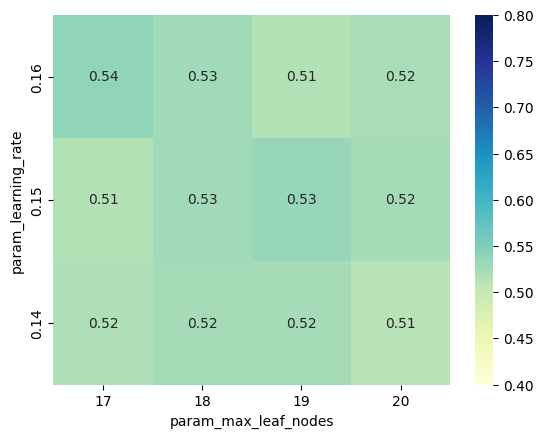

In [33]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

In [22]:
#run histogram gradient boosting model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

gbrt_pipeline = make_pipeline(HistGradientBoostingRegressor(max_leaf_nodes=15,learning_rate=0.16)).set_output(transform="pandas")

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     3.026 +/- 0.385
Root Mean Squared Error: 4.159 +/- 0.550


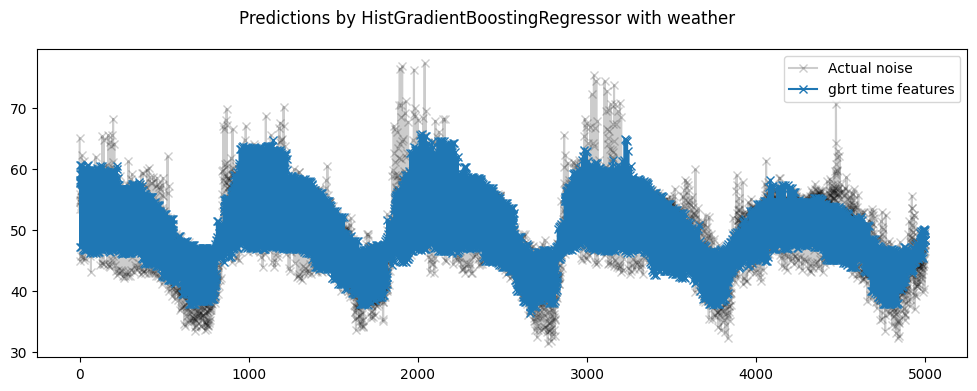

In [36]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

last_hours = slice(-5000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


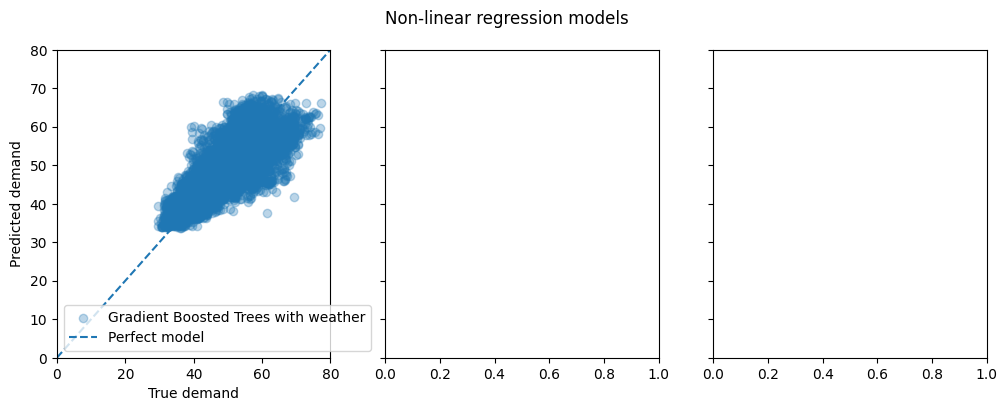

In [35]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()